In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Get the current working directory
current_dir = os.getcwd()

if os.path.isdir(os.path.join(current_dir, 'functions')):
    project_root = current_dir
else:
    project_root = os.path.dirname(current_dir)

if project_root not in sys.path:
    sys.path.append(project_root)

from functions.temporal_schemes import (
    integrate, 
    euler_step, 
    inverse_euler_step, 
    crank_nicolson_step, 
    rk4_step,
    get_numerical_jacobian 
)
from functions.physics import F_oscillator 

from functions.error_analysis import estimate_richardson_error, evaluate_convergence_rate

print(f"Milestone 4 Modules Loaded successfully from: {project_root}")

Milestone 4 Modules Loaded successfully from: C:\MUSE\AM1


In [2]:
def leapfrog_step(u, t, f, dt, **kwargs):
    """
    Symplectic Leap-Frog (Kick-Drift-Kick) integration.
    Assumes u = [positions, velocities] structure.
    """
    n = len(u) // 2
    r_n = u[:n]
    v_n = u[n:]
    
    # First  (v at t + 0.5dt)
    # F returns [velocity, acceleration], need acceleration
    derivs = f(u, t, **kwargs)
    a_n = derivs[n:]
    v_half = v_n + 0.5 * dt * a_n
    
    #Drift (r at t + dt)
    r_next = r_n + dt * v_half
    
    #  Second (v at t + dt)
    # Construct temporary state [r_next, v_half] to evaluate force
    u_temp = np.concatenate((r_next, v_half))
    derivs_next = f(u_temp, t + dt, **kwargs)
    a_next = derivs_next[n:]
    v_next = v_half + 0.5 * dt * a_next
    
    return np.concatenate((r_next, v_next))

### Integrate Linear Oscillator

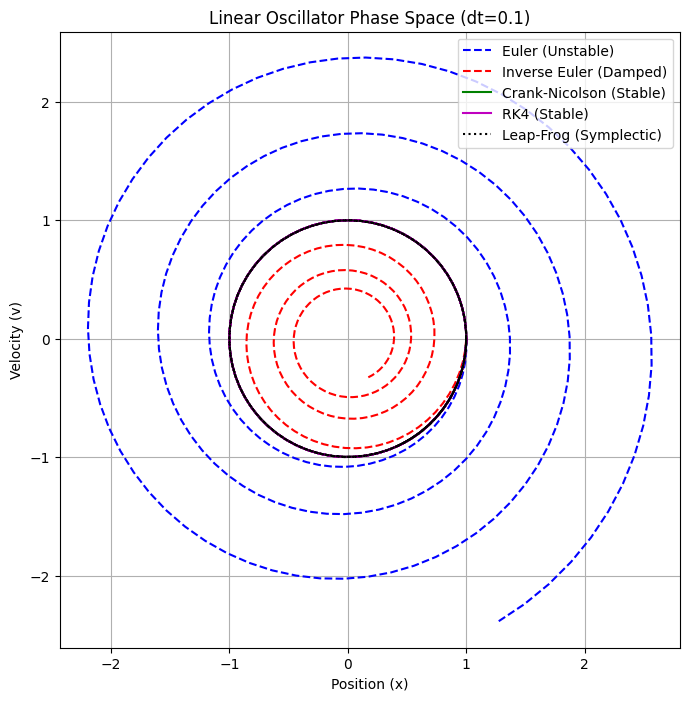

In [3]:
# Equation: x'' + x = 0 

u0 = np.array([1.0, 0.0]) # x=1, v=0
t_span = (0, 20) 
dt = 0.1 

# Helper for implicit solvers
osc_args = {'jacobian_f': lambda u, t: get_numerical_jacobian(F_oscillator, u, t)}

# Run Integrations 
sol_euler, _ = integrate(euler_step, u0, t_span[0], t_span[1], F_oscillator, dt)
sol_inv, _   = integrate(inverse_euler_step, u0, t_span[0], t_span[1], F_oscillator, dt, **osc_args)
sol_cn, _    = integrate(crank_nicolson_step, u0, t_span[0], t_span[1], F_oscillator, dt, **osc_args)
sol_rk4, _   = integrate(rk4_step, u0, t_span[0], t_span[1], F_oscillator, dt)
sol_lf, _    = integrate(leapfrog_step, u0, t_span[0], t_span[1], F_oscillator, dt)

# Plot Phase Space (Velocity vs Position)
plt.figure(figsize=(8, 8))
plt.plot(sol_euler[:,0], sol_euler[:,1], 'b--', label='Euler (Unstable)')
plt.plot(sol_inv[:,0], sol_inv[:,1], 'r--', label='Inverse Euler (Damped)')
plt.plot(sol_cn[:,0], sol_cn[:,1], 'g-', label='Crank-Nicolson (Stable)')
plt.plot(sol_rk4[:,0], sol_rk4[:,1], 'm-', label='RK4 (Stable)')
plt.plot(sol_lf[:,0], sol_lf[:,1], 'k:', label='Leap-Frog (Symplectic)')

plt.title(f"Linear Oscillator Phase Space (dt={dt})")
plt.xlabel("Position (x)")
plt.ylabel("Velocity (v)")
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

### Regions of absolute stability

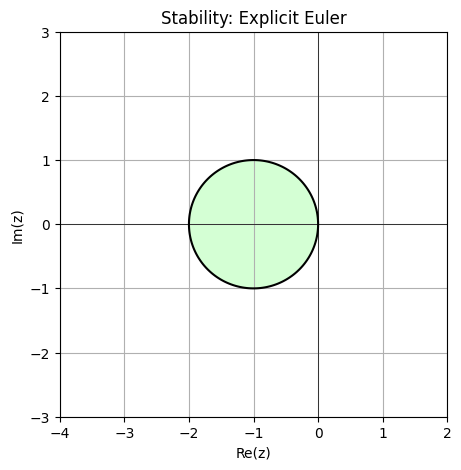

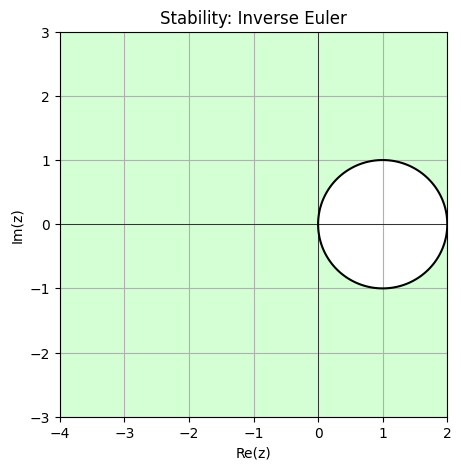

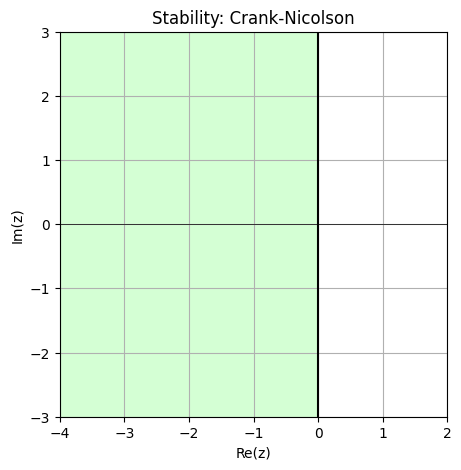

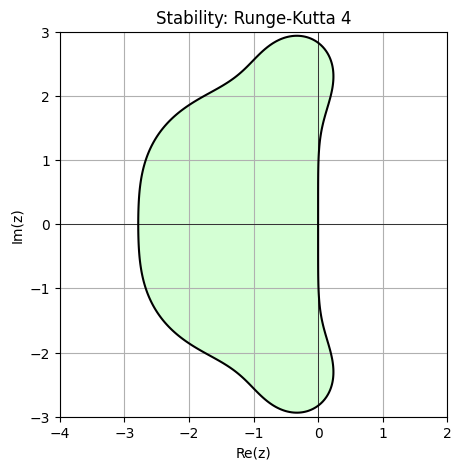

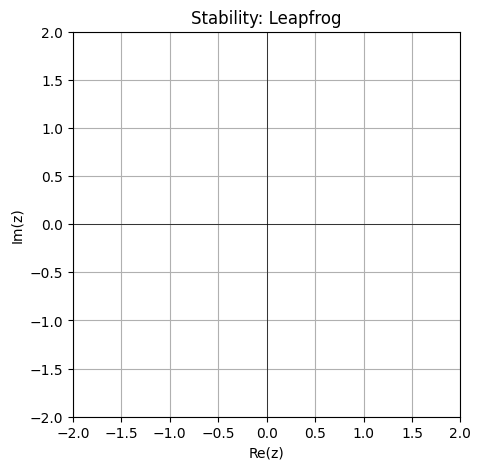

In [4]:
def plot_stability_region(method_name, R_func, xlim=(-4, 2), ylim=(-3, 3)):
    x = np.linspace(xlim[0], xlim[1], 200)
    y = np.linspace(ylim[0], ylim[1], 200)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y
    
    Mag = np.abs(R_func(Z))
    
    plt.figure(figsize=(5, 5))
    plt.title(f"Stability: {method_name}")
    # Green region is stable (|R(z)| <= 1)
    plt.contourf(X, Y, Mag, levels=[0, 1], colors=['#aaffaa'], alpha=0.5)
    plt.contour(X, Y, Mag, levels=[1], colors='k')
    plt.axhline(0, color='k', lw=0.5)
    plt.axvline(0, color='k', lw=0.5)
    plt.xlabel("Re(z)")
    plt.ylabel("Im(z)")
    plt.grid()
    plt.show()

def leapfrog_amp(z):
    r1 = z + np.sqrt(z**2 + 1)
    r2 = z - np.sqrt(z**2 + 1)
    # Stability is determined maximum magnitude of the roots
    return np.maximum(np.abs(r1), np.abs(r2))

    
# 1. Explicit Euler: R(z) = 1 + z
plot_stability_region("Explicit Euler", lambda z: 1 + z)

# 2. Inverse Euler: R(z) = 1 / (1 - z)
plot_stability_region("Inverse Euler", lambda z: 1 / (1 - z))

# 3. Crank-Nicolson: R(z) = (2 + z) / (2 - z)
plot_stability_region("Crank-Nicolson", lambda z: (2 + z) / (2 - z))

# 4. RK4: Taylor series expansion up to 4th order
plot_stability_region("Runge-Kutta 4", lambda z: 1 + z + z**2/2 + z**3/6 + z**4/24)

# Note: The stability region is the interval [-i, i] on the imaginary axis.
plot_stability_region("Leapfrog", leapfrog_amp, xlim=(-2, 2), ylim=(-2, 2))

# Analysis of Stability Results
## Explicit Euler
This method is conditionally stable, meaning the step size $h$ must be small enough so that $z = \lambda h$ remains within the stability circle (centered at $-1$) to prevent error growth. It exhibits very poor stability along the imaginary axis, making it unsuitable for oscillatory problems as it artificially adds energy (amplifies errors) unless an impractically small step size is used.
## Inverse Euler
This method is unconditionally stable for all systems where the eigenvalues have a negative real part ($\operatorname{Re}(\lambda) < 0$). It is extremely robust for transient and steady state systems regardless of step size. The trade-off is twofold: it is computationally expensive (requiring a solver at each step) and it introduces "numerical damping," artificially decaying the solution faster than the physics dictates.
## Crank-Nicolson
Like Inverse Euler, this method is unconditionally stable for all systems where the eigenvalues have a negative real part (stable for the entire left half-plane). Its stability boundary coincides exactly with the imaginary axis. This means it is neutrally stable for purely oscillatory systems: it neither amplifies nor damps the solution. This property of energy conservation makes it the ideal choice for wave equations where preserving the amplitude is critical.
## Runge-Kutta 4
Similar to Explicit Euler, this method is conditionally stable. However, its stability region is significantly larger (the "kidney bean" shape) and covers a meaningful portion of the imaginary axis. This allows for much larger time steps while maintaining high accuracy. It handles non-stiff oscillatory problems well, though for extremely long integration times, it may still exhibit slight energy drift compared to Crank-Nicolson.
## Leapfrog
This method is unique as its stability region is exactly on the imaginary axis. This means that is designed to handle specifically oscillatory systems. As such, it is conditionally stable as long as the step size is small enough such that the eigenvalues stay on this line. This also means that it unstable for any system that has a real component in its eigenvalues.

# Analysis of Numerical Results
For the linear oscillator problem $x'' + x = 0$, the system's eigenvalues are purely imaginary ($\lambda = \pm i$). The behavior of each method in the phase space plot corresponds directly to where the value $z = \lambda \Delta t$ falls within its stability region.

## Explicit Euler (Unstable)
The stability region does not include any part of the imaginary axis (except the origin). Since the eigenvalues $\pm i$ are purely imaginary, they fall outside the stability region. This causes the numerical solution to gain artificial energy, resulting in a spiral that grows to infinity.

## Inverse Euler (Damped)
The stability region includes everything outside the small circle at $+1$. The eigenvalues $\pm i$ fall inside the stable region. However, because $|R(z)| < 1$ strictly for these values, the method introduces "numerical damping," causing the oscillator to lose energy and spiral inward to zero, which is physically incorrect for a frictionless system.

## Crank-Nicolson (Stable)
The stability boundary is exactly the imaginary axis ($|R(z)| = 1$). The eigenvalues fall exactly on this boundary. Consequently, the method neither adds nor removes energy, resulting in a perfect, stable circle in phase space.

## Runge-Kutta 4 (Stable)
The stability region covers a significant portion of the imaginary axis. For a reasonable time step, the value $z = \pm i \Delta t$ falls safely inside. The method produces a stable and highly accurate orbit.

## Leapfrog (Stable)
Since the eigenvalues are purely imaginary and the step size is within the limit ($\Delta t \le 1$), the system falls exactly on the stable line segment $[-i, i]$. The method preserves the orbital structure, resulting in a stable closed loop without the amplitude decay seen in Inverse Euler.